In [1]:
from zappai.database.di import get_session_maker
from zappai.zappai.di import (
    get_cds_api,
    get_crop_repository,
    get_crop_yield_data_repository,
    get_crop_yield_model_service,
    get_location_repository,
    get_past_climate_data_repository,
)
from zappai.zappai.exceptions import CropNotFoundError

session_maker = get_session_maker()
location_repository = get_location_repository()
crop_repository = get_crop_repository()
cds_api = get_cds_api()
past_climate_data_repository = get_past_climate_data_repository(
    cds_api=cds_api,
    location_repository=location_repository,
)
crop_yield_data_repository = get_crop_yield_data_repository(
    crop_repository=crop_repository,
    location_repository=location_repository,
    past_climate_data_repository=past_climate_data_repository,
)
crop_yield_model_service = get_crop_yield_model_service(
    past_climate_data_repository=past_climate_data_repository,
    location_repository=location_repository,
    crop_yield_data_repository=crop_yield_data_repository,
    crop_repository=crop_repository,
)

2024-07-18 15:46:31.906689: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-18 15:46:31.909063: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-18 15:46:31.939523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 15:46:32.584845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
async with session_maker() as session:
    crop = await crop_repository.get_crop_by_name(session=session, name="maize")
    if crop is None:
        raise CropNotFoundError(f'crop with name "maize" not found')
    model, mse, r2, x_train, x_test, y_train, y_test = (
        await crop_yield_model_service.train_crop_yield_model(
            session=session, crop_name=crop.name
        )
    )
x_train

,sowing_year,sowing_month,harvest_year,harvest_month,duration_months,surface_solar_radiation_downwards_mean,surface_solar_radiation_downwards_std,surface_solar_radiation_downwards_min,surface_solar_radiation_downwards_max,surface_thermal_radiation_downwards_mean,...,volumetric_soil_water_layer_3_min,volumetric_soil_water_layer_3_max,2m_temperature_mean,2m_temperature_std,2m_temperature_min,2m_temperature_max,total_precipitation_mean,total_precipitation_std,total_precipitation_min,total_precipitation_max
82,1988,4,1988,9,5,2.059063e+07,3.418220e+06,1.508977e+07,2.505110e+07,3.269154e+07,...,0.209067,0.313626,296.391370,3.935265,290.046728,300.635171,0.004010,0.000862,0.002646,0.005015
51,1984,5,1984,10,5,1.755152e+07,5.557671e+06,9.505862e+06,2.450517e+07,2.897595e+07,...,0.314550,0.413898,289.181581,4.654480,283.861635,294.221191,0.002287,0.000680,0.001532,0.003011
220,1995,5,1995,10,5,1.837583e+07,5.702644e+06,9.054291e+06,2.571818e+07,2.904348e+07,...,0.314097,0.414545,290.168193,4.833956,284.348278,295.617163,0.003519,0.001682,0.001260,0.006179
559,2010,6,2010,10,4,1.746291e+07,4.371849e+06,1.301108e+07,2.428076e+07,3.639185e+07,...,0.194752,0.408199,302.620168,3.271891,299.182772,307.623225,0.005463,0.004842,0.000125,0.010410
544,2010,4,2010,10,6,1.461716e+07,4.879673e+06,7.452067e+06,2.040126e+07,2.838177e+07,...,0.200763,0.318663,287.153222,5.461435,279.780717,294.971077,0.002594,0.001844,0.000320,0.005368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1987,5,1987,10,5,1.963631e+07,4.382000e+06,1.260730e+07,2.390858e+07,3.109678e+07,...,0.236522,0.324691,293.674365,5.604577,282.906133,298.031099,0.002250,0.001002,0.001115,0.003736
106,1989,5,1989,10,5,1.837494e+07,4.092762e+06,1.186796e+07,2.233822e+07,3.022512e+07,...,0.265782,0.395141,291.399604,4.394500,285.214626,296.457702,0.003423,0.001062,0.002123,0.004870
270,1997,5,1997,11,6,1.551674e+07,6.240463e+06,5.530548e+06,2.289144e+07,2.762021e+07,...,0.204068,0.340397,286.028287,6.892536,274.490810,292.982519,0.002663,0.001017,0.001473,0.004291
435,2005,5,2005,10,5,2.046004e+07,5.152227e+06,1.188670e+07,2.590010e+07,3.020796e+07,...,0.204688,0.358768,292.851807,4.944952,285.193609,297.809337,0.002554,0.001795,0.000431,0.005129


In [3]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(x_test.to_numpy())
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
r2 = r2_score(y_true=y_test, y_pred=y_pred)

print(f"r2: {r2}")
print(f"mse: {mse}")
y_pred.shape

r2: 0.44180557725899317
mse: 5975057.361080989


(140,)

<Axes: >

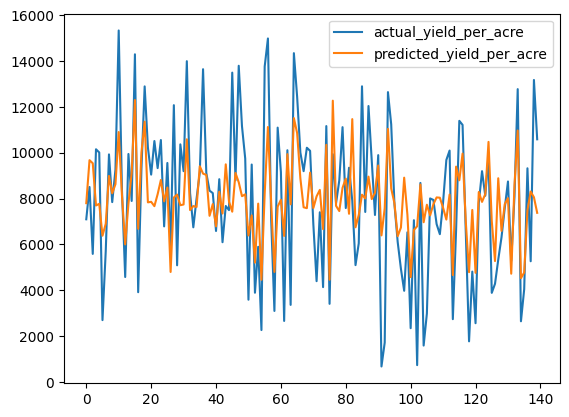

In [4]:
result_df = x_test.copy()
result_df = result_df.reset_index(drop=True)
result_df["actual_yield_per_acre"] = y_test.to_numpy()
result_df["predicted_yield_per_acre"] = y_pred
result_df[["actual_yield_per_acre", "predicted_yield_per_acre"]].plot()